In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
age_groundtruth = pd.read_csv(os.path.join('../input', 'age_groundtruth.csv'), sep=';')
age_annotations = pd.read_csv(os.path.join('../input', 'age_annotations.csv'), sep=';')
age_annotations_set1 = pd.read_csv(os.path.join('../input', 'age_annotations_set1.csv'), sep=';')
age_annotations_set2 = pd.read_csv(os.path.join('../input', 'age_annotations_set2.csv'), sep=';')
golden = {row['SampleID']: row['Age'] for _, row in age_groundtruth.iterrows()}

In [3]:
NUM_SAMPLE = 15
task_known_ids = set(age_annotations['SampleID'].drop_duplicates().sample(NUM_SAMPLE))
task_known = age_annotations[age_annotations['SampleID'].apply(lambda task: task in task_known_ids)]
df = age_annotations.drop(task_known.index)
global_bias = np.mean([golden[task_id] - task['Age'].mean() for task_id, task in task_known.groupby('SampleID')])

In [4]:
# some tools
def evaluate(tasks_v):
    error = np.array([golden[k] - v for k, v in tasks_v.items()])
    return np.power(error, 2).mean()

def task_worker_iter(df, worker_b, task_w, n):
    for _ in range(n):
        # task message
        for task_id, task in df.groupby('SampleID'):
            task_w[task_id] = np.mean([annotation + worker_b[worker_id]
                                            for worker_id, _, annotation in task.values])
        # worker message
        for worker_id, worker in df.groupby('AnnotatorID'):
            worker_b[worker_id] = np.mean([task_w[task_id] - annotation for _, task_id, annotation in worker.values])
            
def eval_df(df, gl_bias):
    wokers_bias = {worker: gl_bias for worker in age_annotations['AnnotatorID'].drop_duplicates()}
    tasks_value = {}
    task_worker_iter(df, wokers_bias, tasks_value, 5)
    return evaluate(tasks_value)

def eval_num_sample(num_sample):
    task_known_ids = set(age_annotations['SampleID'].drop_duplicates().sample(num_sample))
    task_known = age_annotations[age_annotations['SampleID'].apply(lambda task: task in task_known_ids)]
    df = age_annotations.drop(task_known.index)
    bias = np.mean([golden[task_id] - task['Age'].mean() for task_id, task in task_known.groupby('SampleID')])

    return eval_df(df, bias)

bias = truevalue - annotation

truevalue = bias + annotation

In [5]:
%%time
x = range(1, 21)
y = np.zeros(20)
wokers_bias = {worker: global_bias for worker in age_annotations['AnnotatorID'].drop_duplicates()}
tasks_value = {}
for i in x:
    task_worker_iter(df, wokers_bias, tasks_value, 1)
    y[i-1] = evaluate(tasks_value)

CPU times: user 9.67 s, sys: 92 ms, total: 9.76 s
Wall time: 9.65 s


In [6]:
y

array([138.20191636, 137.29017542, 137.17866469, 137.15861745,
       137.15407216, 137.1528514 , 137.15247207, 137.15233723,
       137.15228345, 137.15226006, 137.15224929, 137.15224418,
       137.1522417 , 137.15224049, 137.15223989, 137.1522396 ,
       137.15223946, 137.15223938, 137.15223935, 137.15223933])

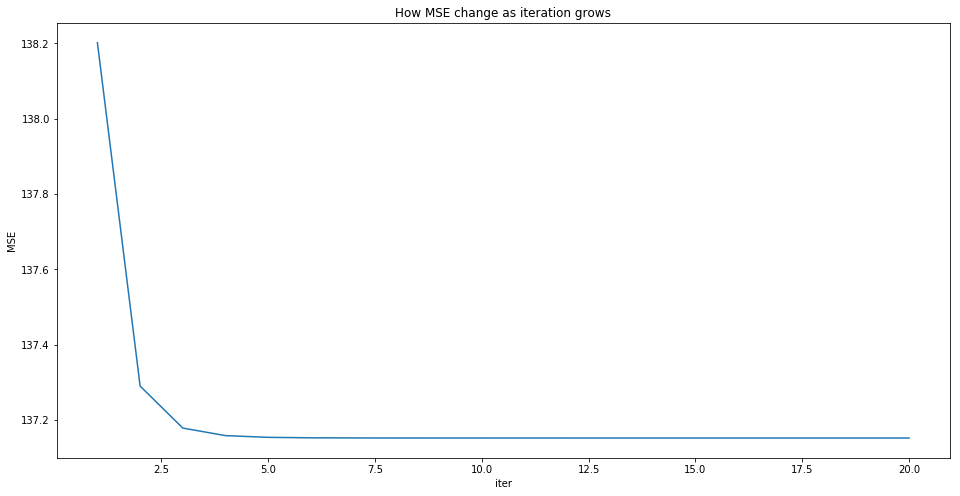

In [7]:
plt.figure(figsize=(16,8))
plt.plot(x, y)
plt.xlabel('iter')
plt.ylabel('MSE')
plt.title('How MSE change as iteration grows')
plt.show()

# How sample size change the result

In [8]:
%%time
x = range(10, 20)
y = []
for i in x:
    task_known_ids = set(age_annotations['SampleID'].drop_duplicates().sample(i + 1))
    task_known = age_annotations[age_annotations['SampleID'].apply(lambda task: task in task_known_ids)]
    local_df = age_annotations.drop(task_known.index)
    g_bias = np.mean([golden[task_id] - task['Age'].mean() for task_id, task in task_known.groupby('SampleID')])
    y.append(eval_df(local_df, g_bias))
    
y = np.array(y)

CPU times: user 24.9 s, sys: 184 ms, total: 25.1 s
Wall time: 24.8 s


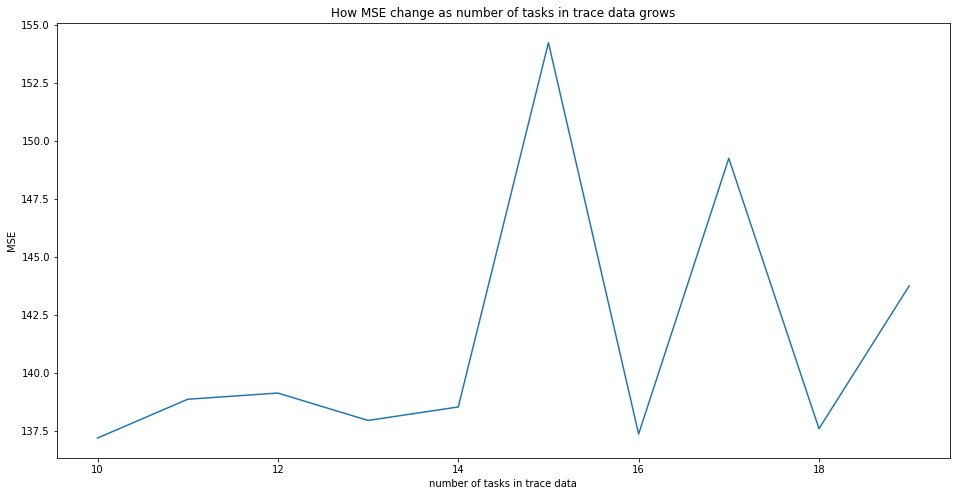

In [9]:
plt.figure(figsize=(16,8))
plt.plot(x, y)
plt.xlabel('number of tasks in trace data')
plt.ylabel('MSE')
plt.title('How MSE change as number of tasks in trace data grows')
plt.show()

trivial mean squre error for the simple everging method

In [10]:
error_mean = np.array([golden[task_id] - task['Age'].mean() for task_id, task in age_annotations.groupby('SampleID')])
np.power(error_mean, 2).mean()

298.8732865889993